必要なもん入れる

In [1]:
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt

# from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

from torchvision import transforms, datasets
# from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F

%matplotlib inline

image_size = (64, 64)

`transform`の定義

In [2]:
# 複数のコードで使われていたのでそういうおまじないっぽい
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]
transform = transforms.Compose([
                                transforms.Resize(image_size),
                                #transforms.Grayscale(num_output_channels=3),
                                transforms.ToTensor(),
                                transforms.Normalize(mean, std)])

In [3]:
train_path = './cat-and-dog/training_set/training_set'
test_path  = './cat-and-dog/test_set/test_set'

train_data = datasets.ImageFolder(train_path, transform=transform)
train_loader = DataLoader(train_data, batch_size=50, shuffle=True)

classes = ('cat', 'dog')

In [4]:
test_data = datasets.ImageFolder(test_path, transform=transform)
test_loader = DataLoader(test_data, batch_size=5, shuffle=False)

In [5]:
def imshow(img):
  img = img/2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1,2,0)))
  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


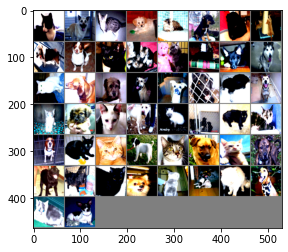

In [6]:
data_iter = iter(train_loader) # ランダムにイテレーション取得
images, labels = data_iter.next()


imshow(torchvision.utils.make_grid(images))
# print(' '.join('%5s' % classes[labels[j]] for j in range(16)))

In [7]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()

    # 畳み込み・プーリング
    self.conv1 = nn.Conv2d(3, 6, 5) # 入力チャネル，出力チャネル，カーネル
    self.pool  = nn.MaxPool2d(2, 2) # プーリングカーネル
    self.conv2 = nn.Conv2d(6, 16, 5)
    # 全結合層
    self.fc1 = nn.Linear(16 * 13 * 13, 120) # 入力，出力
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 2)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 13 * 13)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x
  
net = Net()

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [9]:
for epoch in range(10):
  print('epoch: %d' %(epoch+1))
  running_loss = 0.0
  for i, data in enumerate(train_loader, 0):
    # 訓練データから入力画像行列とラベルを取り出す
    inputs, labels = data

    # 勾配を初期化
    optimizer.zero_grad()

    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    if i % 120 == 119:
      print('[%d, %5d] loss: %.3f' %
            (epoch + 1, i + 1, running_loss / 120))
      running_loss = 0.0

print('Finished Training')

epoch: 1
[1,   120] loss: 0.671
epoch: 2
[2,   120] loss: 0.582
epoch: 3
[3,   120] loss: 0.515
epoch: 4
[4,   120] loss: 0.480
epoch: 5
[5,   120] loss: 0.420
epoch: 6
[6,   120] loss: 0.340
epoch: 7
[7,   120] loss: 0.246
epoch: 8
[8,   120] loss: 0.170
epoch: 9
[9,   120] loss: 0.111
epoch: 10
[10,   120] loss: 0.087
Finished Training


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


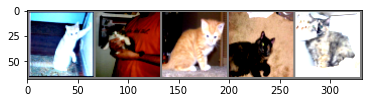

GroundTruth:    cat   cat   cat   cat   cat


In [13]:
# テストデータを適当に持ってくる
test_iter = iter(test_loader)
images, labels = test_iter.next()

# 画像表示
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(5)))

In [14]:
outputs = net(images)
_, predicted = torch.max(outputs, 1) # 入力した画像の行列の最大値

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(5)))

Predicted:    cat   dog   cat   cat   cat


In [15]:
correct = 0
total = 0
with torch.no_grad(): # パラメータの保存ストップ
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the %d test images: %d %%' % (
    total,
    100 * correct / total))

Accuracy of the network on the 2023 test images: 72 %


In [17]:
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))
with torch.no_grad():
    for data in test_loader:
        if min(class_total) > 1000:
            break
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(5):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(2):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))


Accuracy of   cat : 71 %
Accuracy of   dog : 72 %
